# Appling machine learning to audio analysis

## Code for Predicting 

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/7e2b0b92791a4f909d5cc739b424cc89



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Functions to extract the MFCCs from every file in our dataset

In [6]:
# funçao com gerador que guarda os valores da atual posição da janela e calcula os proximos
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        yield start, start + window_size # a função para aqui e returna o valor para a outra função
        start += (window_size // 10) #calcula a posição inicial do proximo segmento

In [7]:
def extract_features(file_name, window_size):
    #upload do audio
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #list de retorno
    mfccsArr = []
    
    # A função gerador é um iteravel a partir dos valores gerados durante a keyword yield
    #Percorre um audio inteiro
    for (start,end) in windows(audio, window_size):
        #Enquanto a janela nao atingir o fim do audio
        if end <= len(audio): 
            #entao define um excerto do audio
            signal = audio[start:end]
            # e calcula os coeficientes de mel
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
            mfccs_processed = np.mean(mfccs.T,axis=0)
            mfccsArr.append([mfccs_processed])
    # Retorna os coeficientes de mel em forma de lista do audio inteiro
    return mfccsArr

### Code to save the MFCCs

In [8]:
features = []# Iterate through each sound file and extract the features 

df = pd.read_csv('../csvFiles/set_a - copia.csv')

windowSize = 3000

In [9]:
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    
    data = extract_features(file_name, windowSize)
    
    for item in data:
        features.append(item)
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature'])

In [10]:
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


In [11]:
featuresdf.iloc[0]['feature']
fileMFCCs = '../MFCCs/completeSetA_' + str(windowSize) + '.pkl'
featuresdf.to_pickle(fileMFCCs) 

## Model's Predections

### Load Model from saved files

In [12]:
model = load_model('../model_save/cut_setA', compile = True)

In [13]:
fileMFCCs = '../MFCCs/completeSetA_' + '3000' + '.pkl'
featuresdf = pd.read_pickle(fileMFCCs)
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


### Predections (SOFTMAX func)

In [14]:
X = np.array(featuresdf.feature.tolist())
predictions = model.predict(X)

In [15]:
print(predictions)

[[6.19481580e-06 1.22907941e-05 9.99981523e-01]
 [2.40208417e-12 1.95304918e-11 1.00000000e+00]
 [4.79978834e-10 1.61264846e-09 1.00000000e+00]
 ...
 [4.67530084e-15 1.04640621e-13 1.00000000e+00]
 [5.36373619e-15 5.43316917e-14 1.00000000e+00]
 [1.01769804e-16 1.00749328e-15 1.00000000e+00]]


### Plot of Predictions

In [16]:
colSone = []
colSTwo = []
colNoise = []
for item in predictions:
    
    colSone.append(item[0])
    colSTwo.append(item[1])
    colNoise.append(item[2])

In [17]:
# considering above certain value

# to get the position of S1 and S2:   
positionS1 = dict() 
positionS2 = dict()

for k in colSone:
    if k>0.65:
        index = colSone.index(k) # gets the index from the element
        positionS1[index]=k # adds the element as a value to the index as a key
        
for k in colSTwo:
    if k>0.45:
        index = colSTwo.index(k)
        positionS2[index]=k

In [18]:
# S1 in a 75 interval
position1 = dict() 
positionS1 = dict() 
while len(colSone)<600:
    colSone.append(0)
k=0
for i in range(75,601,75):
    position1[i] = []
    for z in range(k, i):
        position1[i].append(colSone[z])
        #print(z)
    k+=75
    #print('add')
for i in position1:
    m1 = max(position1[i])
    index = colSone.index(m1) # gets the index from the element
    positionS1[index]=m1 # adds the element as a value to the index as a key

In [19]:
# S2 in a 75 interval
position2 = dict()
positionS2 = dict()
while len(colSTwo)<600:
    colSTwo.append(0)
k=0
for i in range(75,601,75):
    position2[i] = []
    for z in range(k, i):
        position2[i].append(colSTwo[z])
        #print(z)
    k+=75
    #print('add')
for i in position2:
    m2 = max(position2[i])
    index = colSTwo.index(m2) # gets the index from the element
    positionS2[index]=m2 # adds the element as a value to the index as a key

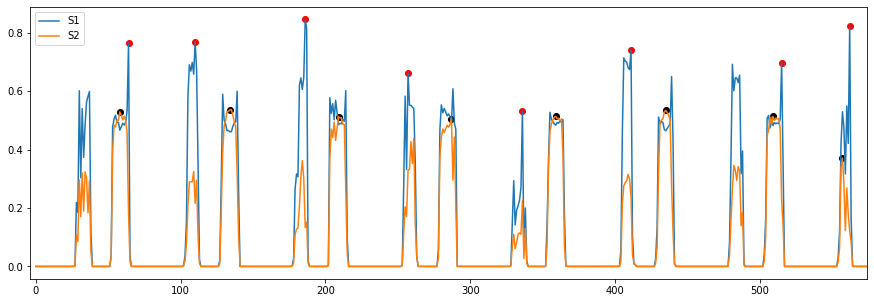

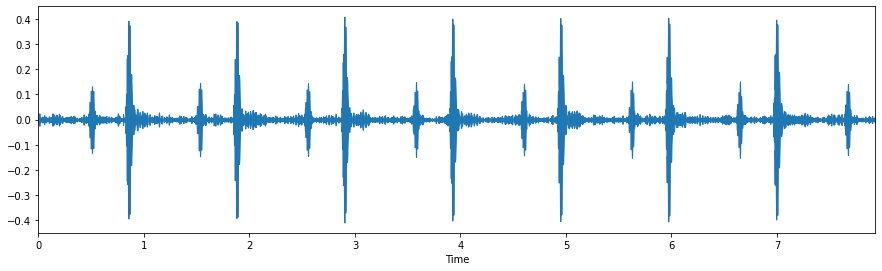

In [20]:
# plots:

plt.figure(figsize=(15,5))
plt.plot(colSone, label='S1')
plt.plot(colSTwo, label='S2')
#plt.plot(colNoise, label='Noise')
plt.xlim(-4, 574)
plt.scatter(positionS1.keys(), positionS1.values(), c='red')
plt.scatter(positionS2.keys(), positionS2.values(), c='black')
plt.legend()

# plot waves of S1
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.add_subplot(2,1,2)
name = '../set_a/normal__201108011114.wav'
data, sample_rate = librosa.load(name)
librosa.display.waveplot(data, sr = sample_rate)

In [24]:
lista1 = []
for position in positionS1:
    lista1.append(position)
print('S1 positions:',lista1)

a = lista1[0]
final1 = []
for i in range(len(lista1)):
    if i>0: # ignores first value
        b = lista1[i]-a # subtract the values
        final1.append(b)
    a = lista1[i]
    
lista2 = []
for position in positionS2:
    lista2.append(position)
print('S2 positions:',lista2)

a = lista2[0]
final2 = []
for i in range(len(lista2)):
    if i>0: # ignores first value
        b = lista2[i]-a # subtract the values
        final2.append(b)
    a = lista2[i]
    
print(final1, final2)

S1 positions: [64, 110, 186, 257, 336, 411, 515, 562]
S2 positions: [58, 134, 209, 287, 359, 435, 509, 557]
[46, 76, 71, 79, 75, 104, 47] [76, 75, 78, 72, 76, 74, 48]


In [ ]:
experiment.end()